In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [89]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':15,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'big hidden layers':3,
        'big epochs': 1000,
        'big lr': 0.01
        }

# Data Prep

In [90]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [91]:
df = pd.read_excel('wide_range.xlsx')

In [92]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [93]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [94]:
# scale for training
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [95]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [96]:
# add noise
X_noisy = add_noise(X, args['noise'])

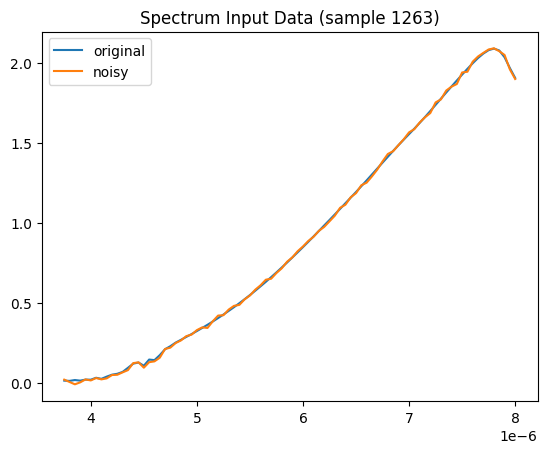

In [97]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [98]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [100]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

In [101]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [102]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [103]:
class BigNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(BigNet, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 11: hidden_size = 11
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [104]:
criterion = args['train criterion']

In [105]:
print("Individual Layer Training")
for layer in layers:
    features = X_train_tensor
    target = layer['y_train']

    # instantiate model
    model = FeedForward(features.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(features)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

Individual Layer Training
layer 1
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]


epoch: 50, loss = 13.247559547424316
epoch: 100, loss = 8.227511405944824
epoch: 150, loss = 7.534654140472412
epoch: 200, loss = 7.283936977386475
epoch: 250, loss = 7.086366176605225
epoch: 300, loss = 6.957536697387695
epoch: 350, loss = 6.880069255828857
epoch: 400, loss = 6.839439868927002
epoch: 450, loss = 6.817493915557861
epoch: 500, loss = 6.807684898376465
best loss: 6.807467460632324 in epoch 499

layer 2
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16, 10, 5]
epoch: 50, loss = 11.28546142578125
epoch: 100, loss = 8.857767105102539
epoch: 150, loss = 8.229203224182129
epoch: 200, loss = 7.857202529907227
epoch: 250, loss = 7.665477752685547
epoch: 300, loss = 7.539552688598633
epoch: 350, loss = 7.463317394256592
epoch: 400, loss = 7.39234733581543
epoch: 450, loss = 7.352141380310059
epoch: 500, loss = 7.322809219360352
best loss: 7.322809219360352 in epoch 500

layer 3
hidden layer sizes: [86, 80, 75, 69, 64, 59, 53, 48, 43, 37, 32, 26, 21, 16,

In [106]:
big_net = BigNet(len(X.columns)+len(y.columns), len(y.columns), args['big hidden layers'])
optimizer = torch.optim.Rprop(big_net.parameters(), lr=args['big lr'])

best_loss = np.inf
best_epoch = 0
train_losses = []

features = X_train.copy()
features.index = range(len(features))

for layer in layers:
    pred = layer['model'](X_train_tensor)
    pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
    features = pd.concat([features, pred], axis=1)

features = torch.tensor(features.values, dtype=torch.float32)
target = torch.tensor(y_train.values, dtype=torch.float32)

print("Big Net Training")
print(f'hidden layer sizes: {big_net.hidden_sizes}')
for epoch in range(args['big epochs']):
    # forward pass
    outputs = big_net(features)

    # get loss
    loss = criterion(outputs, target)

    # update and backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch+1

    if (epoch+1) % int(args['train epochs']/10) == 0:
        print(f'epoch: {epoch+1}, loss = {loss}')


Big Net Training
hidden layer sizes: [97, 72, 48, 24]
epoch: 50, loss = 10.01709270477295
epoch: 100, loss = 6.585143566131592
epoch: 150, loss = 5.2859578132629395
epoch: 200, loss = 5.136407375335693
epoch: 250, loss = 5.1081414222717285
epoch: 300, loss = 4.9249348640441895
epoch: 350, loss = 4.755094528198242
epoch: 400, loss = 4.683568000793457
epoch: 450, loss = 4.645798683166504
epoch: 500, loss = 4.624943256378174
epoch: 550, loss = 4.615044593811035
epoch: 600, loss = 4.6057820320129395
epoch: 650, loss = 4.5973358154296875
epoch: 700, loss = 4.591588497161865
epoch: 750, loss = 4.58701753616333
epoch: 800, loss = 4.577885150909424
epoch: 850, loss = 4.570984840393066
epoch: 900, loss = 4.565787315368652
epoch: 950, loss = 4.560712814331055
epoch: 1000, loss = 4.555746555328369


In [117]:
little_losses = []
test_criterion = args['test criterion']

print("Individual Model Test Losses")

for layer in layers:
    features = X_test_tensor
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(features)
        loss = test_criterion(pred, target)
        little_losses.append(loss.item())

    print(f'{layer["col"]} loss: {loss.item()}')
print(sum(little_losses) / len(little_losses))

Individual Model Test Losses
layer 1 loss: 8.34885025024414
layer 2 loss: 9.245163917541504
layer 3 loss: 5.674470901489258
layer 4 loss: 5.7358622550964355
layer 5 loss: 5.350661754608154
layer 6 loss: 4.922168731689453
layer 7 loss: 5.757839679718018
layer 8 loss: 4.330636501312256
layer 9 loss: 4.299722671508789
layer 10 loss: 3.4738285541534424
layer 11 loss: 0.978147029876709
5.283395658839833


In [108]:
def make_predictions(X):
    features = X.copy()
    features.index = range(len(features))

    features_tensor = torch.tensor(features.values, dtype=torch.float32)

    for layer in layers:
        pred = layer['model'](features_tensor)
        pred = pd.DataFrame(pred.detach().numpy(), columns=[f'{layer["col"]} predictions'])
        features = pd.concat([features, pred], axis=1)

    features = torch.tensor(features.values, dtype=torch.float32)

    return big_net(features)

In [115]:
big_losses = []
with torch.no_grad():
    pred = make_predictions(X_test)
    overall_loss = criterion(pred, y_test_tensor)
    print("Overall Loss for Big Net: {}".format(overall_loss.item()))

    print("Per Layer Loss for Big Net")
    for layer in layers:
        loss = criterion(pred[layer['layer']-1], y_test_tensor[layer['layer']-1])
        print(f'{layer["col"]} loss: {loss.item()}')
        big_losses.append(loss.item())

Overall Loss for Big Net: 5.330984115600586
Per Layer Loss for Big Net
layer 1 loss: 5.245874404907227
layer 2 loss: 3.9854652881622314
layer 3 loss: 4.908366680145264
layer 4 loss: 2.747300624847412
layer 5 loss: 6.665724277496338
layer 6 loss: 4.421750068664551
layer 7 loss: 4.523162841796875
layer 8 loss: 5.804698467254639
layer 9 loss: 3.0704429149627686
layer 10 loss: 2.5688560009002686
layer 11 loss: 5.659909248352051


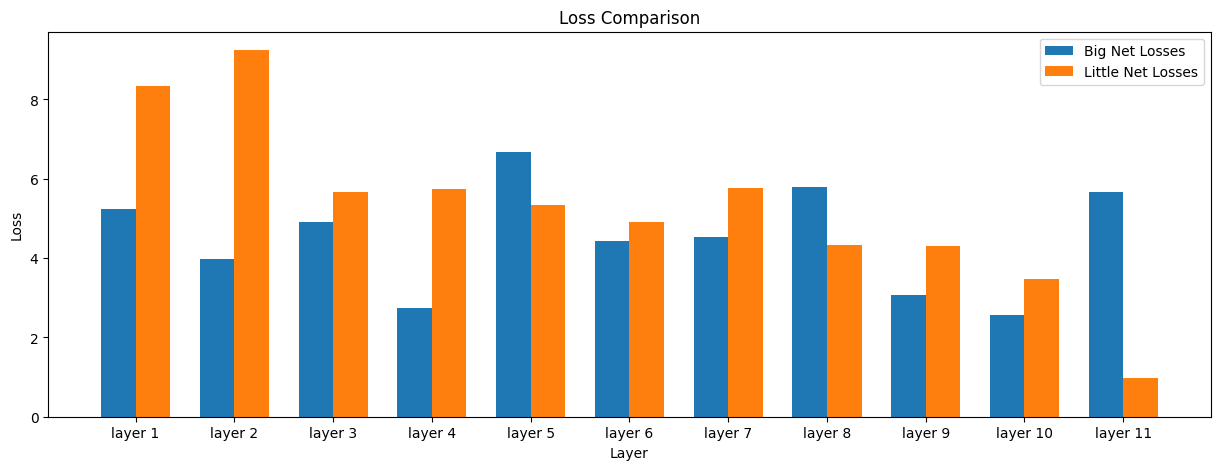

In [110]:
index = np.arange(11)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,5))
summer = ax.bar(index, big_losses, bar_width,
                label="Big Net Losses")

winter = ax.bar(index+bar_width, little_losses,
                 bar_width, label="Little Net Losses")

ax.set_xlabel('Layer')
ax.set_ylabel('Loss')
ax.set_title('Loss Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(y.columns)
ax.legend()

plt.show()

In [111]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [112]:
actual_df = y_test
pred_df = pd.DataFrame(make_predictions(X_test).detach().numpy())
pred_df.columns = actual_df.columns

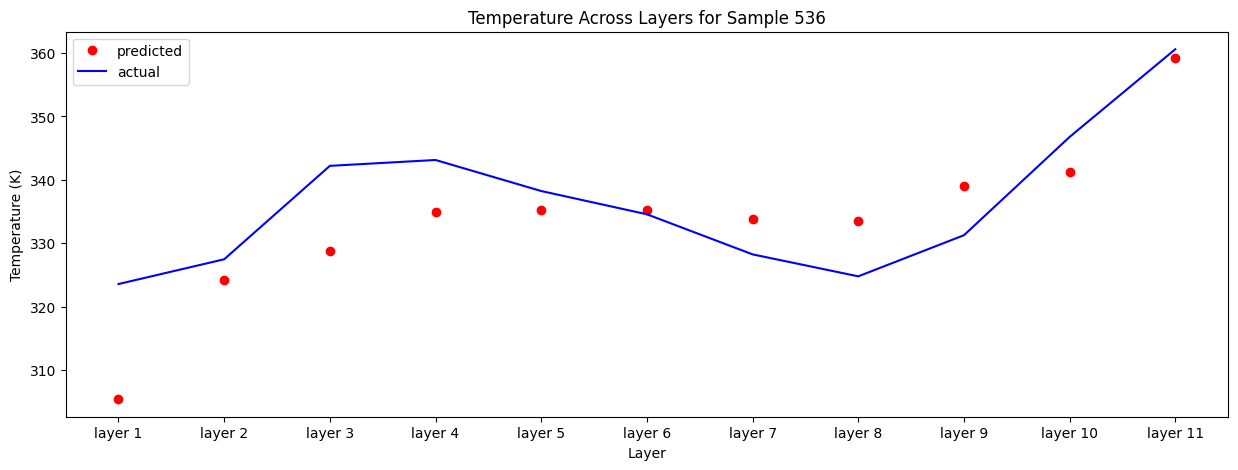

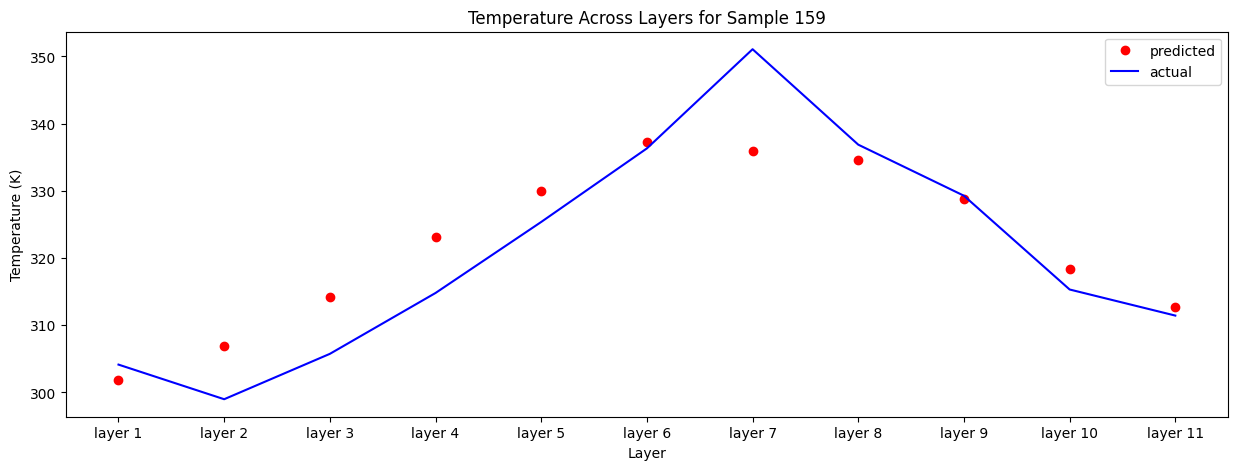

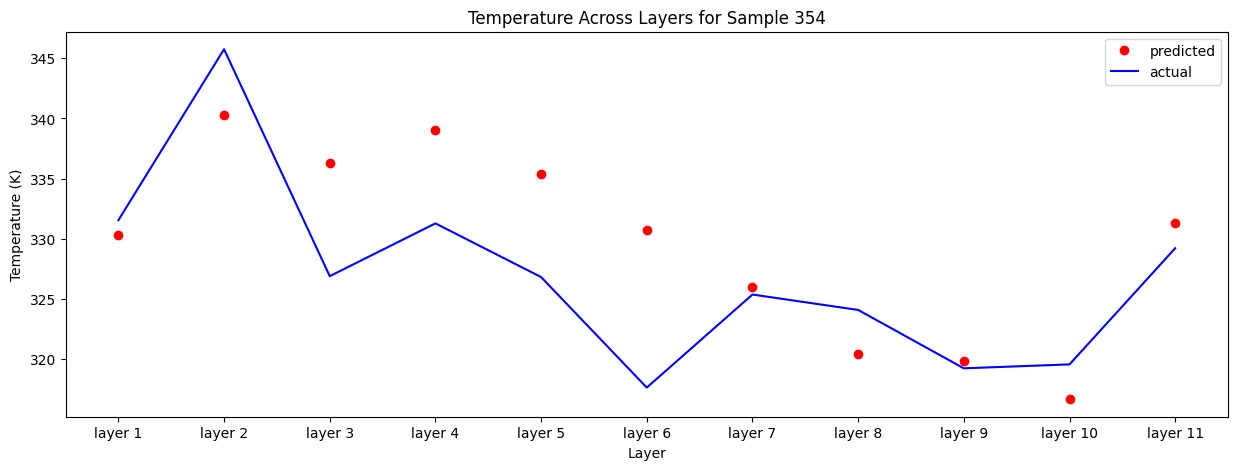

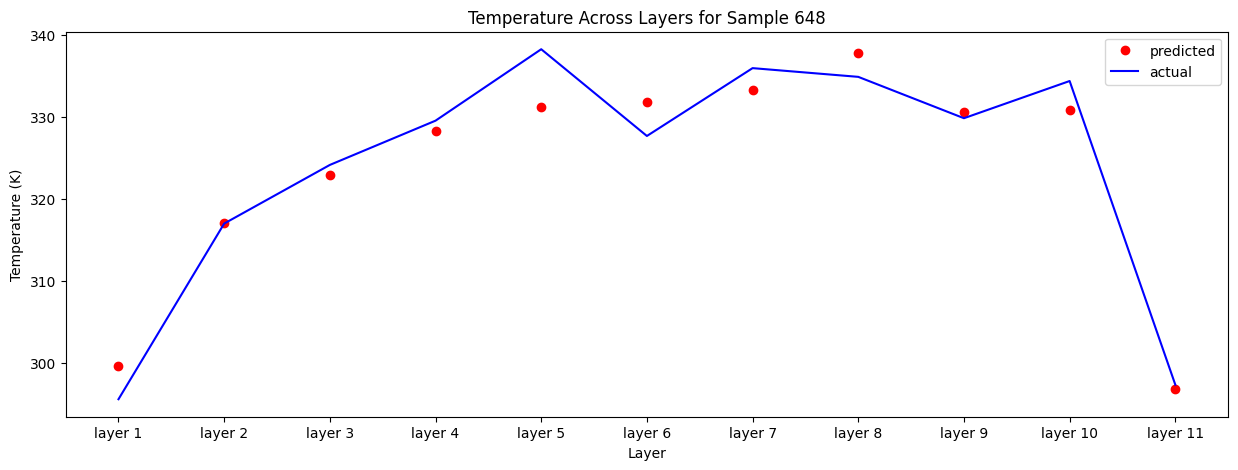

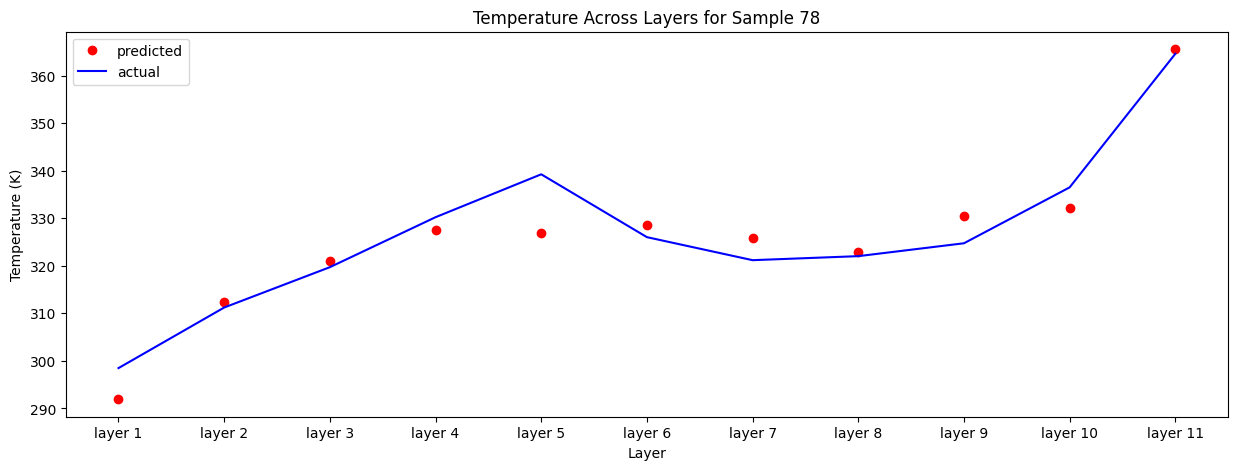

In [113]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)